<a href="https://colab.research.google.com/github/rogercost/fire-guardrails/blob/main/Guardrails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import requests
import numpy as np
import pandas as pd

from pathlib import Path

 ### Load Shiller's CSV file with monthly market data


In [ ]:
def parse_shiller_date(series):
    """
    Convert Shiller-style yyyy.mm strings/floats into proper datetimes.
    Examples:
      1950.01 -> 1950-01-01
      1950.1  -> 1950-10-01
      1950.11 -> 1950-11-01
    """
    s = series.astype(str).str.strip()

    def _norm(val):
        year, month_part = val.split(".", 1)
        # Special case: .1 means October (Excel dropped the zero)
        if month_part == "1":
            month = "10"
        else:
            month = month_part.zfill(2)
        return f"{year}-{month}-01"

    return pd.to_datetime(s.map(_norm), format="%Y-%m-%d")

In [ ]:
local_path = Path(os.path.join("tempdir", "shillerdata.xls"))
url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/9becfac9-1778-47a6-b40e-299d8c616706/ie_data.xls"

# Check if file exists and is less than 30 days old
def needs_update(path, days=30):
    if not path.exists():
        return True
    age_days = (time.time() - path.stat().st_mtime) / (24 * 3600)
    return age_days > days

# Download if missing or outdated
if needs_update(local_path):
    local_path.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

# Read multi-line headers (rows 4–7) and collapse them
headers_raw = pd.read_excel(local_path, sheet_name="Data", skiprows=4, nrows=4, header=None)
headers = (
    headers_raw.fillna("")
    .astype(str)
    .agg(" ".join)           # join rows into one string
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)  # clean spaces
)

# Read the actual data (starting row 8)
df = pd.read_excel(local_path, sheet_name="Data", skiprows=8)
df.columns = headers

# Drop the last row which contains footnotes
df = df.iloc[:-1].reset_index(drop=True)

df["Date"] = parse_shiller_date(df["Date"])

df.tail()

,Date,S&P Comp. P,Dividend D,Earnings E,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Earnings Ratio P/E10 or CAPE,,Earnings Ratio TR P/E10 or TR CAPE,,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
1851,2025-05-01,5810.919524,76.948434,221.363333,321.465,2025.375000,4.42,5846.136807,77.414782,3.937395e+06,...,35.076007,NaN,37.636543,NaN,0.014912,1.006896,39.258095,NaN,NaN,NaN
1852,2025-06-01,6029.9515,77.350000,223.700000,322.561,2025.458333,4.38,6045.883451,77.554369,4.076277e+06,...,36.108975,NaN,38.730193,NaN,0.014487,1.002847,39.394513,NaN,NaN,NaN
1853,2025-07-01,6296.498182,NaN,NaN,323.048,2025.541667,4.39,6303.617235,NaN,4.250048e+06,...,37.469882,NaN,40.132464,NaN,0.013530,1.014158,39.447119,NaN,NaN,NaN
1854,2025-08-01,6408.949524,NaN,NaN,323.2915,2025.625000,4.26,6411.363103,NaN,4.322692e+06,...,38.031442,NaN,40.708786,NaN,0.014659,1.005976,39.975485,NaN,NaN,NaN
1855,2025-08-01,6415.54,NaN,NaN,323.41325,2025.708333,4.23,6415.540000,NaN,4.325509e+06,...,37.972942,NaN,40.621525,NaN,0.015199,NaN,40.199255,NaN,NaN,NaN


### Define a function to compute the time series of portfolio values with customized withdrawals

In [ ]:
def portfolio_with_withdrawals(df, withdrawals, initial_value=1_000_000):
    """
    df: DataFrame with 'Date' (YYYY-MM-dd) and 'Real Total Return Price'
    withdrawals: DataFrame with ['Date', 'Withdrawal'] aligned with df['Date']
    """
    df = df.copy()
    df = df.merge(withdrawals, on="Date", how="inner").fillna({"Withdrawal": 0.0})

    # Normalize return index
    base = df["Real Total Return Price"].iloc[0]
    df["GrowthFactor"] = df["Real Total Return Price"] / base

    values = []
    value = initial_value
    last_factor = 1.0

    for _, row in df.iterrows():
        # Withdrawal happens at start of period
        value -= row["Withdrawal"]

        # Growth happens during the period
        growth = row["GrowthFactor"] / last_factor
        value *= growth

        values.append(value)
        last_factor = row["GrowthFactor"]

    df["Period End Value"] = values
    return df[["Date", "Period End Value", "Withdrawal"]]

### Now use it to run the 4% rule.

In [ ]:
def get_constant_withdrawals(data, start_date, end_date, initial_value=1_000_000, percent_level=0.04):
    """
    Create a dataframe of constant withdrawals over a date range.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing a "Date" column (yyyy.mm format).
    start_date : pd.DateTime
        Starting date of the withdrawal range.
    end_date : pd.DateTime
        Ending date of the withdrawal range.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000).
    percent_level : float, optional
        Annual withdrawal rate (default 0.04 = 4%).

    Returns
    -------
    pd.DataFrame
        A dataframe with Date and Withdrawal columns.
    """
    data = data.copy()

    # filter range
    mask = (data["Date"] >= start_date) & (data["Date"] <= end_date)
    subset = data.loc[mask, ["Date"]].reset_index(drop=True)

    # compute withdrawal value
    withdrawal_value = initial_value * percent_level / 12
    subset["Withdrawal"] = withdrawal_value

    return subset

In [ ]:
withdrawals_df = get_constant_withdrawals(df, start_date="1962-01-01", end_date="2011-12-01")
print(withdrawals_df.head())

        Date   Withdrawal
0 1962-01-01  3333.333333
1 1962-02-01  3333.333333
2 1962-03-01  3333.333333
3 1962-04-01  3333.333333
4 1962-05-01  3333.333333


In [ ]:
four_percent_portfolio = portfolio_with_withdrawals(df, withdrawals_df)
four_percent_portfolio.head()

,Date,Period End Value,Withdrawal
0,1962-01-01,9.966667e+05,3333.333333
1,1962-02-01,1.008946e+06,3333.333333
2,1962-03-01,1.009050e+06,3333.333333
3,1962-04-01,9.728742e+05,3333.333333
4,1962-05-01,8.998865e+05,3333.333333


In [ ]:
four_percent_portfolio.tail()

,Date,Period End Value,Withdrawal
595,2011-08-01,708913.882640,3333.333333
596,2011-09-01,698964.328847,3333.333333
597,2011-10-01,718133.298294,3333.333333
598,2011-11-01,728066.083129,3333.333333
599,2011-12-01,737840.955129,3333.333333


### Plot the portfolio value and withdrawal over the period

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import numpy as np

def plot_portfolio(df):
    """
    Create two stacked plots:
    1. Portfolio value over time (Y axis in $M, adaptive tick/grid spacing, min at 0 or below if needed)
    2. Withdrawals over time (Y axis in $K, with 1K horizontal guidelines, as bars)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Plot 1: Portfolio values ---
    ax1.plot(df["Date"], df["Period End Value"], label="Portfolio Value", linewidth=2)

    # Adaptive y-axis ticks
    y_min, y_max = df["Period End Value"].min(), df["Period End Value"].max()
    y_range = y_max - y_min
    candidates = [100_000, 500_000, 1_000_000, 5_000_000]
    step = min(candidates, key=lambda c: abs((y_range / c) - 10))

    # Round limits to multiples of step
    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax1.axhline(0, color="lightgray", linewidth=1)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title("Portfolio with Withdrawals")
    ax1.legend()

    # --- Plot 2: Withdrawals (bars) ---
    ax2.bar(df["Date"], df["Withdrawal"],
            color="tab:red", alpha=0.7, label="Withdrawal", width=20)

    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    w_step = 1000  # fixed 1K spacing
    w_min_final = min(0, np.floor(w_min / w_step) * w_step)
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax2.set_ylabel("Withdrawals")
    ax2.legend()

    # Shared x-axis
    ax2.set_xlabel("Date")
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.tight_layout()
    plt.show()


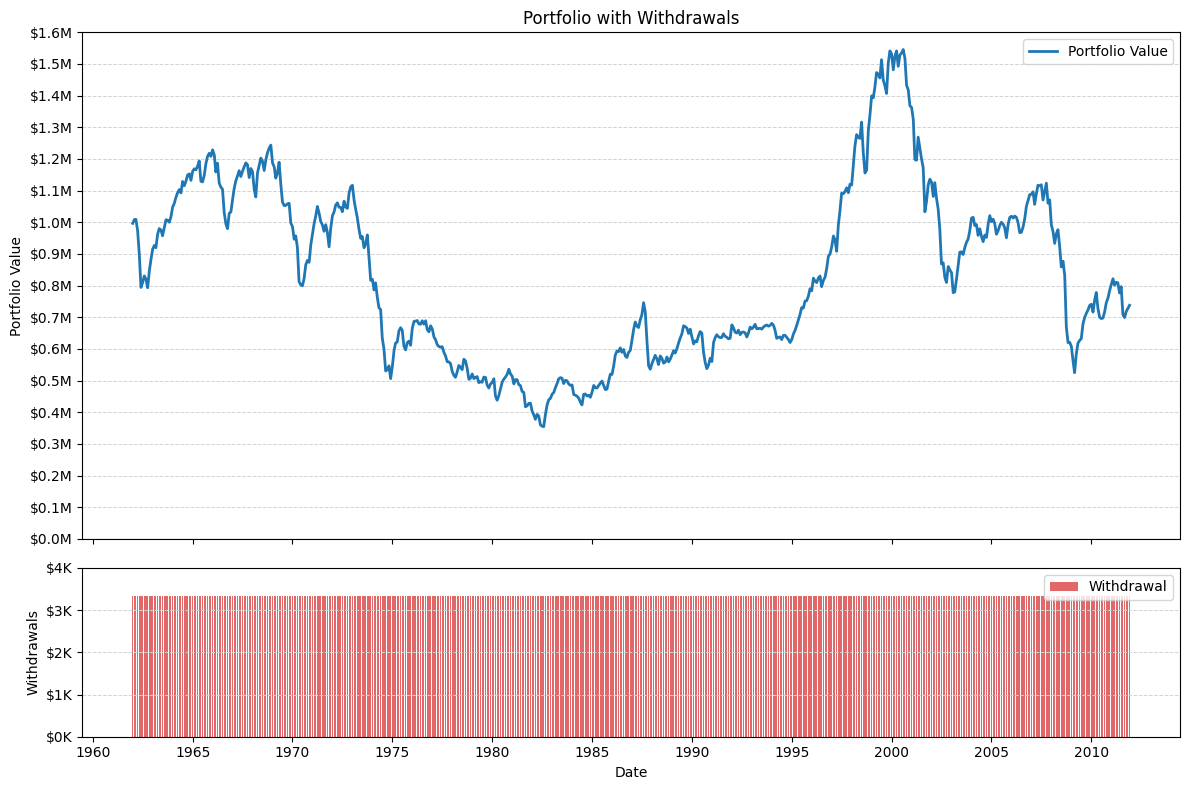

In [ ]:
plot_portfolio(four_percent_portfolio)

In [ ]:
def get_guardrail_withdrawals(data, start_date, end_date, initial_value=1_000_000, **kwargs):
    """
    Create a dataframe of constant withdrawals over a date range.

    Parameters
    ----------
    --- TBD

    Returns
    -------
    pd.DataFrame
        A dataframe with Date and Withdrawal columns.
    """
    data = data.copy()

    # filter range
    mask = (data["Date"] >= start_date) & (data["Date"] <= end_date)
    subset = data.loc[mask, ["Date"]].reset_index(drop=True)

    previous_spending = 0
    previous_spending_basis_date = '1800-01-01'

    ## Guardrail strategy
    for each date in subset:
        # Calculate the value
        # 1) Recalculate the guardrails based on portfolio value
        # 2) May adjust the spending based on either (a) inflation or (b) spending change IF guardrail is hit

        # TODO rename all variables to match the Main tab of the Everyone Adjusts! spreadsheet

        # To recalculate the guardrails

        # 1. Find the withdrawal rate that results in a 90% success rate from Karste's sheet - Parameters & Main Results - cell E23 (?).
        #    It has to be done every month because the # in B28 (months remaining) decreases each time. This is the "target" value.

        target_spending = # karsten's calc at 90% WITH CURRENT portfolio value - this will move around

        # 2. Now we have to back out what the portfolio level would be AT this target spending level for the % chance of success to become 100%.
        #    We can either guess and check in Karsten's sheet - or try and replicate what FIRE Calc is doing when we say give me the PF value
        #    we need to make a given spending level a given chance of success.
        #    I am guessing firecalc has a precomputed 3d cube: duration, start date, success %. (And asset allocation but we'll leave that for later)

        upper_guardrail_pf_value = # what firecalc does with the target spending for 100% success rate
        lower_guardrail_pf_value = # what firecalc does with the target spending for 75% success rate

        # 3. Determine if we hit the guardrail. If our current portfolio value is at or above this upper guardrail portfolio value, then we hit it.

        hit_upper_guardrail = portfolio_value > upper_guardrail_pf_value
        hit_lower_guardrail = portfolio_value < lower_guardrail_pf_value

        upper_adjustment_fraction = 1.0
        lower_adjustment_fraction = 0.1

        # 4. If we hit a guardrail, adjust by the configured fraction

        new_proposed_spending = target_spending

        if hit_upper_guardrail:
            new_proposed_spending = target_spending * upper_adjustment_fraction

        if hit_lower_guardrail:
            new_proposed_spending = target_spending * lower_adjustment_fraction

        # 5. We now have to inflation adjust the new proposed spending with a baseline of wherever we last derived it from.
        #    We'll use this to determine if we hit the threshold, but it isn't a meaningful number - it's e.g. a 1960 number adjusted for the period from 1982-1985
        #    (assuming 1982 was the last time we advised the client to adjust their spending). We run the whole simulation in constant dollars, so we don't use this
        #    number for anything else in the math. (We'll *properly* inflation adjust the final spending recommendation before sending it to the client!)

        new_proposed_adj_spending = apply_inflation(new_proposed_spending, previous_spending_basis_date, date)

        # 5. Finally - only adjust spending if this adjusted spending is over configured threshold.
        #    If it is, this means that either guardrail hit and/or

        over_threshold = abs((new_proposed_adj_spending - portfolio_value) / portfolio_value) > 0.05

        if over_threshold:
            new_spending = target_spending * upper_adjustment_fraction
        else:
            new_spending = previous_spending

        subset["Withdrawal"] = withdrawal_value

        # Carry state into the next iteration
        previous_spending = new_spending

    return subset